## Problem Discription:
In this project, you will use deep learning to predict forest cover type (the most common kind of tree cover) based only on \
cartographic variables. The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS)\
Region 2 Resource Information System data. The covertypes are the following:
- Spruce/Fir
- Lodgepole Pine
- Ponderosa Pine
- Cottonwood/Willow
- Aspen
- Douglas-fir
- Krummholz

## Project Objectives:
- Develop one or more classifiers for this multi-class classification problem.
- Use TensorFlow with Keras to build your classifier(s). 
- Use your knowledge of hyperparameter tuning to improve the performance of your model(s).
- Test and analyze performance.
- Create clean and modular code.

## Preprocess and explore the dataset

In [1]:
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
import os


from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [71]:
data_df = pd.read_csv('dlsp-portfolio-solution-code/cover_data.csv')
data_df.head()
data_df.values

raw_data_df = data_df
X, y = raw_data_df.iloc[:, :-1], raw_data_df.iloc[:, -1]
print(type(X))
print(X)
print(type(y))
print(y)

# check number of classes
print(y.nunique()) #７



<class 'pandas.core.frame.DataFrame'>
        Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0            2596      51      3                               258   
1            2590      56      2                               212   
2            2804     139      9                               268   
3            2785     155     18                               242   
4            2595      45      2                               153   
...           ...     ...    ...                               ...   
581007       2396     153     20                                85   
581008       2391     152     19                                67   
581009       2386     159     17                                60   
581010       2384     170     15                                60   
581011       2383     165     13                                60   

        Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                                    0        

## Type Distributions- Visualising with Histogram using Matplotlib

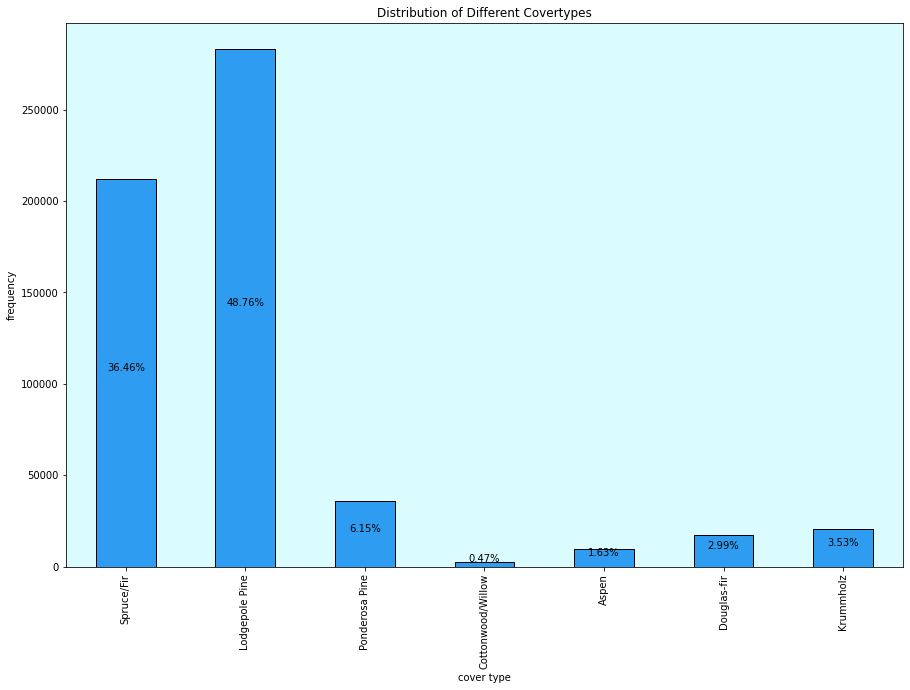

In [68]:
# create a list of our conditions
conditions = [
    data['class'] == 1,
    data['class'] == 2,
    data['class'] == 3,
    data['class'] == 4,
    data['class'] == 5,
    data['class'] == 6,
    data['class'] == 7
]

# create a list of the values we want to assign for each condition
values = [
    'Spruce/Fir',
    'Lodgepole Pine',
    'Ponderosa Pine',
    'Cottonwood/Willow',
    'Aspen',
    'Douglas-fir',
    'Krummholz'
]

# create a new column and use np.select to assign values to it using our lists as arguments
data_df['cover_type'] = np.select(conditions, values)


fig = plt.subplots(1, 1, figsize = (15, 10))

# Visualisation
ax = data_df['cover_type'].value_counts().loc[values].plot(kind = 'bar', color = '#2E9CF0', edgecolor = '#000000')
ax.set_title('Distribution of Different Covertypes')
ax.set_xlabel('cover type')
ax.set_ylabel('frequency')
ax.set_facecolor('#DAFCFE')


heights = [covertype.get_height() for covertype in ax.patches]
height_max = max(heights)
total_height = sum(heights)

for covertype in ax.patches:
    percentage = covertype.get_height() / total_height
    height = covertype.get_height() 
    ax.text(covertype.get_x() + covertype.get_width() / 2, 
            covertype.get_y() + height / 2,
            "%.2f%%" %(percentage * 100),
            color = '#000000',
            ha = 'center', 
            va = 'bottom')

# Save before displaying
plt.savefig('distribution of cover types.png')

plt.show()




In [75]:
covertype0 = ax.patches[0]
covertype0.get_height()
max(heights)

raw_data_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


# Split the raw data into training and test data
trainX, testX, trainy, testy = train_test_split(X, y, test_size = .3, stratify = y, shuffle = True, random_state = 30)
print(trainX)
print('trainX: ', trainX.shape)
print(trainy)
print('testX: ', trainy.shape)

# Normalise data
scaler = StandardScaler()
trainX_normalised = scaler.fit_transform(trainX)
testX_normalised = scaler.transform(testX)
print(trainX_normalised)
print(testX_normalised)

# Check number of classes
print(trainy.nunique()) # 7
print(testy.nunique()) # 7

# One-hot Encoding- Necessary step for multi-class classification tasks
# trainy = to_categorical(trainy)
# testy = to_categorical(testy)


# NOTE: index starting from 1, rather than default 0. Convert y - y.min() to binary code!
trainy = to_categorical(trainy - trainy.min())
testy = to_categorical(testy - testy.min())




        Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
323337       2682      16     14                               295   
111655       3228     188      2                               576   
189434       3022      11      5                                30   
551930       2877     185     21                                 0   
54738        3004     117      4                               911   
...           ...     ...    ...                               ...   
442511       2981     337      8                               390   
513677       3074      33     19                               663   
182150       3035     270      6                               283   
307043       3048     193      5                                60   
257345       2226     304     23                               342   

        Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
323337                              48                              351   
111655   

In [77]:
print('trainy: \r\n', trainy)
print('testy: \r\n', testy)

trainy: 
 [[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
testy: 
 [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


## Build our multi-class classifier using deep network

In [13]:
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import AUC, CategoricalCrossentropy, Accuracy
from tensorflow.keras.optimizers import Adam


def design_classifier_1(features, n_classes):
    
    model = Sequential(name = 'forest_cover_type_classifier')
    
    input = InputLayer(input_shape = (features.shape[1], ))
    model.add(input)
    model.add(Dense(64, activation = 'relu'))
    # model.add(Dropout(.3)) # Dropout layer is not needed for small-architectured model
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(n_classes, activation = 'softmax')) # output layer: #(classes) = number of uniquelabels
    
    # tuning hyperparameters
    opt = Adam(learning_rate = 1e-3)
    loss_func = tf.keras.losses.CategoricalCrossentropy()
    
    model.compile(loss = 'categorical_crossentropy', metrics = [AUC(), CategoricalCrossentropy(), Accuracy()], optimizer = opt)
    
    model.summary()
    
    return model

In [20]:
print(trainX_normalised.shape[1])
print(trainX_normalised.shape)
print(trainy.shape)
print(testy.shape)
print(trainy[:5])

54
(406708, 54)
(406708, 8)
(174304, 8)
[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


In [22]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold, StratifiedKFold # cross validation
from sklearn.model_selection import cross_val_score
from tensorflow.keras.utils import to_categorical

# K-fold cross validation
kf = KFold(n_splits = 10, random_state = 30, shuffle = True)
skf = StratifiedKFold(n_splits = 10, random_state = 30, shuffle = True)



clf = design_classifier_1(trainX_normalised, trainy.shape[1])

# Set an early stopping callback
es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 10)

# Train the model without cross validation
print('[INFO] Fitting model...')
history = clf.fit(trainX_normalised, trainy, validation_split = .25, epochs = 100, batch_size = 1024, callbacks = [es], verbose = 1)

# Train the model with cross validation
print('[INFO] Scoring model with cross validation...')
# scores = cross_val_score(clf, trainX_normalised, trainy, scoring = 'accuracy', callbacks = [es], cv = kf, n_jobs = -1)


# Evaluate model
print('[INFO] Evaluating model without cross validation...')
score = clf.evaluate(testX_normalised, testy, verbose = 1)

Model: "forest_cover_type_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                3520      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 264       
Total params: 5,864
Trainable params: 5,864
Non-trainable params: 0
_________________________________________________________________
[INFO] Fitting model...
Epoch 1/100
298/298 [==============================] - 3s 9ms/step - loss: 0.8144 - auc_4: 0.9519 - categorical_crossentropy: 0.8144 - accuracy: 1.8031e-05 - val_loss: 0.6319 - val_auc_4: 0.9686 - val_categorical_crossentropy: 0.6319 - val_accuracy: 2.7046e-05
Epoch 2/100
298/298 [==============================] - 3s 8ms/step - loss: 0.6032

298/298 [==============================] - 2s 8ms/step - loss: 0.3906 - auc_4: 0.9873 - categorical_crossentropy: 0.3906 - accuracy: 2.7948e-04 - val_loss: 0.3949 - val_auc_4: 0.9870 - val_categorical_crossentropy: 0.3949 - val_accuracy: 2.8153e-04
Epoch 30/100
298/298 [==============================] - 2s 8ms/step - loss: 0.3879 - auc_4: 0.9874 - categorical_crossentropy: 0.3879 - accuracy: 2.9382e-04 - val_loss: 0.3930 - val_auc_4: 0.9871 - val_categorical_crossentropy: 0.3930 - val_accuracy: 2.9874e-04
Epoch 31/100
298/298 [==============================] - 2s 8ms/step - loss: 0.3865 - auc_4: 0.9875 - categorical_crossentropy: 0.3865 - accuracy: 3.1021e-04 - val_loss: 0.3895 - val_auc_4: 0.9873 - val_categorical_crossentropy: 0.3895 - val_accuracy: 3.2702e-04
Epoch 32/100
298/298 [==============================] - 2s 8ms/step - loss: 0.3841 - auc_4: 0.9877 - categorical_crossentropy: 0.3841 - accuracy: 3.2251e-04 - val_loss: 0.3870 - val_auc_4: 0.9876 - val_categorical_crossentropy:

298/298 [==============================] - 2s 8ms/step - loss: 0.3323 - auc_4: 0.9905 - categorical_crossentropy: 0.3323 - accuracy: 0.0088 - val_loss: 0.3405 - val_auc_4: 0.9900 - val_categorical_crossentropy: 0.3405 - val_accuracy: 0.0088
Epoch 93/100
298/298 [==============================] - 2s 8ms/step - loss: 0.3322 - auc_4: 0.9905 - categorical_crossentropy: 0.3322 - accuracy: 0.0092 - val_loss: 0.3460 - val_auc_4: 0.9896 - val_categorical_crossentropy: 0.3460 - val_accuracy: 0.0099
Epoch 94/100
298/298 [==============================] - 2s 8ms/step - loss: 0.3314 - auc_4: 0.9905 - categorical_crossentropy: 0.3314 - accuracy: 0.0100 - val_loss: 0.3380 - val_auc_4: 0.9901 - val_categorical_crossentropy: 0.3380 - val_accuracy: 0.0103
Epoch 95/100
298/298 [==============================] - 2s 8ms/step - loss: 0.3317 - auc_4: 0.9905 - categorical_crossentropy: 0.3317 - accuracy: 0.0105 - val_loss: 0.3411 - val_auc_4: 0.9899 - val_categorical_crossentropy: 0.3411 - val_accuracy: 0.01

## Save / Load a trained model